<a href="https://colab.research.google.com/github/aarohishaiva/CNN_final-Project/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Generate a Synthetic Dataset
We'll create a dataset where each source sequence is a random sequence of integers, and each target sequence is the reverse of the source sequence.

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class ReverseDataset(Dataset):
    def __init__(self, num_samples=10000, seq_length=10, vocab_size=100):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.data = self._generate_data()

    def _generate_data(self):
        data = []
        for _ in range(self.num_samples):
            source = np.random.randint(1, self.vocab_size, self.seq_length)
            target = source[::-1]
            data.append((source, target))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = ReverseDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


2. Implement Seq2Seq Model with Attention Mechanism
We'll define the Encoder, Decoder, and Attention mechanisms using PyTorch.

In [ ]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs, hidden, cell

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear((hid_dim * 2) + hid_dim, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[0]
        hidden = hidden[-1].repeat(src_len, 1, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=0)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM((hid_dim * 2) + emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[t] = output
            top1 = output.argmax(1)
            input = trg[t] if np.random.random() < teacher_forcing_ratio else top1
        return outputs


3. Train the Model
We'll train the model using the synthetic dataset.

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # Repeat hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # [batch size, src len, dec_hid_dim]

        # Concatenate hidden state with encoder outputs
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch size, src len, dec_hid_dim]

        attention = self.v(energy).squeeze(2)  # [batch size, src len]

        return F.softmax(attention, dim=1)  # [batch size, src len]


In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)  # [1, batch size]
        embedded = self.dropout(self.embedding(input))  # [1, batch size, emb dim]

        a = self.attention(hidden, encoder_outputs)  # [batch size, src len]
        a = a.unsqueeze(1)  # [batch size, 1, src len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # [batch size, src len, enc_hid_dim * 2]

        weighted = torch.bmm(a, encoder_outputs)  # [batch size, 1, enc_hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)  # [1, batch size, enc_hid_dim * 2]

        rnn_input = torch.cat((embedded, weighted), dim=2)  # [1, batch size, (enc_hid_dim * 2) + emb_dim]

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)  # [batch size, emb dim]
        output = output.squeeze(0)  # [batch size, dec_hid_dim]
        weighted = weighted.squeeze(0)  # [batch size, enc_hid_dim * 2]

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))  # [batch size, output dim]

        return prediction, hidden.squeeze(0), a.squeeze(1)


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        input = trg[0, :]

        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            input = output.argmax(1)  # Next input is current output

        return outputs


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F


In [ ]:
vocab = ['word1', 'word2', 'word3', ...]  # Replace with your actual vocabulary
INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class YourDataset(torch.utils.data.Dataset):
    def __init__(self):
        # Initialize your dataset here
        self.data = None  # Replace with your actual data
        pass

    def __len__(self):
        # Return the total number of samples
        return len(self.data)  # Return the length of your data

    def __getitem__(self, idx):
        # Return a sample from your dataset
        pass

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        # Define your attention mechanism

    def forward(self, hidden, encoder_outputs):
        # Implement your attention mechanism forward pass
        pass

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)  # input shape: [1, batch size]
        embedded = self.dropout(self.embedding(input))  # embedded shape: [1, batch size, emb dim]

        a = self.attention(hidden, encoder_outputs)  # attention shape: [batch size, src len]
        a = a.unsqueeze(1)  # attention shape: [batch size, 1, src len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs shape: [batch size, src len, enc_hid_dim * 2]

        weighted = torch.bmm(a, encoder_outputs)  # weighted shape: [batch size, 1, enc_hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)  # weighted shape: [1, batch size, enc_hid_dim * 2]

        rnn_input = torch.cat((embedded, weighted), dim=2)  # rnn_input shape: [1, batch size, (enc_hid_dim * 2) + emb_dim]

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)  # embedded shape: [batch size, emb dim]
        output = output.squeeze(0)  # output shape: [batch size, dec_hid_dim]
        weighted = weighted.squeeze(0)  # weighted shape: [batch size, enc_hid_dim * 2]

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))  # prediction shape: [batch size, output_dim]

        return prediction, hidden.squeeze(0), a.squeeze(1)


In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for batch_idx, (src, trg) in enumerate(iterator):
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        output, _, _ = model(src, trg[:,:-1])  # Pass trg without the last token for teacher forcing

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)  # Shifted target

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


In [ ]:
import torch

tensor1 = torch.randn(3)
tensor2 = torch.randn(3) # Change the shape of tensor2 to match tensor1

stacked = torch.stack([tensor1, tensor2])
print(stacked)

tensor([[-0.5483,  1.4566,  0.9874],
        [-1.8238, -0.2973,  0.0449]])


In [ ]:
from torch.nn.utils.rnn import pad_sequence

# Example of padding sequences to the same length
tensor1 = torch.randn(3, 4)  # Example tensor 1
tensor2 = torch.randn(2, 4)  # Example tensor 2

# Pad sequences to the same length (e.g., 3)
padded_tensor1 = pad_sequence([tensor1, tensor2], batch_first=True, padding_value=0)


In [ ]:
tensor1 = torch.randn(3, 4)
tensor2 = torch.randn(3, 4)
print(tensor1.shape, tensor2.shape)  # Check shapes before stacking


torch.Size([3, 4]) torch.Size([3, 4])


In [ ]:
import torch

tensor1 = torch.randn(3, 4)  # Shape [3, 4]
tensor2 = torch.randn(3, 4)  # Shape [3, 4]

tensor2_reshaped = tensor2.unsqueeze(0)  # Shape [1, 3, 4]

# Now both tensors have the same shape [1, 3, 4] along dim=0
stacked = torch.cat([tensor1.unsqueeze(0), tensor2_reshaped], dim=0)
print(stacked.shape)  # Output: torch.Size([2, 3, 4])


torch.Size([2, 3, 4])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import random
import numpy as np

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)  # input shape: [1, batch size]
        embedded = self.dropout(self.embedding(input))  # embedded shape: [1, batch size, emb dim]
        a = self.attention(hidden, encoder_outputs)  # attention shape: [batch size, src len]
        a = a.unsqueeze(1)  # attention shape: [batch size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs shape: [batch size, src len, enc_hid_dim * 2]
        weighted = torch.bmm(a, encoder_outputs)  # weighted shape: [batch size, 1, enc_hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)  # weighted shape: [1, batch size, enc_hid_dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)  # rnn_input shape: [1, batch size, (enc_hid_dim * 2) + emb_dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        embedded = embedded.squeeze(0)  # embedded shape: [batch size, emb dim]
        output = output.squeeze(0)  # output shape: [batch size, dec_hid_dim]
        weighted = weighted.squeeze(0)  # weighted shape: [batch size, enc_hid_dim * 2]
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))  # prediction shape: [batch size, output_dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            top1 = output.argmax(1)
            input = trg[t] if random.random() < teacher_forcing_ratio else top1
        return outputs

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(model.device), trg.to(model.device)
        optimizer.zero_grad()

        # Ensure all indices are within the valid range
        src = torch.clamp(src, 0, INPUT_DIM - 1)
        trg = torch.clamp(trg, 0, OUTPUT_DIM - 1)

        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Example batch size
BATCH_SIZE = 32

# Custom collate function for DataLoader
def collate_fn(batch):
    srcs = [torch.tensor(item[0].copy()) for item in batch]
    trgs = [torch.tensor(item[1].copy()) for item in batch]
    srcs = pad_sequence(srcs, batch_first=True, padding_value=0)
    trgs = pad_sequence(trgs, batch_first=True, padding_value=0)
    return srcs, trgs

# Example dataset
# Replace with your actual dataset
class ExampleDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = [
            (np.array([1, 2, 3]), np.array([1, 2, 3])),
            (np.array([4, 5]), np.array([4, 5]))
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_data = ExampleDataset()

# DataLoader instantiation
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Define your vocabulary here
vocab = {'<PAD>': 0, '<SOS>': 1, '}': 2}

INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Training loop
N_EPOCHS = 10
CLIP = 1

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}')


Epoch: 01, Train Loss: 1.094
Epoch: 02, Train Loss: 0.395
Epoch: 03, Train Loss: 0.098
Epoch: 04, Train Loss: 0.037
Epoch: 05, Train Loss: 0.009
Epoch: 06, Train Loss: 0.003
Epoch: 07, Train Loss: 0.000
Epoch: 08, Train Loss: 0.000
Epoch: 09, Train Loss: 0.000
Epoch: 10, Train Loss: 0.000


4. Evaluate the Model
We'll evaluate the model using accuracy and loss metrics.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import random
import numpy as np

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)  # input shape: [1, batch size]
        embedded = self.dropout(self.embedding(input))  # embedded shape: [1, batch size, emb dim]
        a = self.attention(hidden, encoder_outputs)  # attention shape: [batch size, src len]
        a = a.unsqueeze(1)  # attention shape: [batch size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs shape: [batch size, src len, enc_hid_dim * 2]
        weighted = torch.bmm(a, encoder_outputs)  # weighted shape: [batch size, 1, enc_hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)  # weighted shape: [1, batch size, enc_hid_dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)  # rnn_input shape: [1, batch size, (enc_hid_dim * 2) + emb_dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        embedded = embedded.squeeze(0)  # embedded shape: [batch size, emb dim]
        output = output.squeeze(0)  # output shape: [batch size, dec_hid_dim]
        weighted = weighted.squeeze(0)  # weighted shape: [batch size, enc_hid_dim * 2]
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))  # prediction shape: [batch size, output_dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            top1 = output.argmax(1)
            input = trg[t] if random.random() < teacher_forcing_ratio else top1
        return outputs

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(model.device), trg.to(model.device)
        optimizer.zero_grad()

        # Ensure all indices are within the valid range
        src = torch.clamp(src, 0, INPUT_DIM - 1)
        trg = torch.clamp(trg, 0, OUTPUT_DIM - 1)

        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def accuracy(output, target):
    _, predicted = torch.max(output, dim=1)
    correct = (predicted == target).float()
    acc = correct.sum() / len(correct)
    return acc

def evaluate_model(model, dataloader):
    model.eval()
    total_acc = 0
    total_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src = src.permute(1, 0).to(device)
            trg = trg.permute(1, 0).to(device)
            output = model(src, trg, 0)  # no teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            acc = accuracy(output, trg)
            total_loss += loss.item()
            total_acc += acc.item()
    return total_loss / len(dataloader), total_acc / len(dataloader)

# Example batch size
BATCH_SIZE = 32

# Custom collate function for DataLoader
def collate_fn(batch):
    srcs = [torch.tensor(item[0].copy()) for item in batch]
    trgs = [torch.tensor(item[1].copy()) for item in batch]
    srcs = pad_sequence(srcs, batch_first=True, padding_value=0)
    trgs = pad_sequence(trgs, batch_first=True, padding_value=0)
    return srcs, trgs

# Example dataset
# Replace with your actual dataset
class ExampleDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = [
            (np.array([1, 2, 3]), np.array([1, 2, 3])),
            (np.array([4, 5]), np.array([4, 5]))
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_data = ExampleDataset()

# DataLoader instantiation
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Define your vocabulary here
vocab = {'<PAD>': 0, '<SOS>': 1, '}': 2}

INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


# Training loop
N_EPOCHS = 10
CLIP = 1
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP) # Use train_loader instead of train_dataloader
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}')

Epoch: 01, Train Loss: 1.053
Epoch: 02, Train Loss: 0.478
Epoch: 03, Train Loss: 0.274
Epoch: 04, Train Loss: 0.112
Epoch: 05, Train Loss: 0.015
Epoch: 06, Train Loss: 0.004
Epoch: 07, Train Loss: 0.001
Epoch: 08, Train Loss: 0.000
Epoch: 09, Train Loss: 0.000
Epoch: 10, Train Loss: 0.000


5. Plot Loss Curves and Performance Metrics
We'll visualize the loss curves and other metrics.

Epoch: 01, Train Loss: 1.069, Val Loss: 0.443
Epoch: 02, Train Loss: 0.386, Val Loss: 0.394
Epoch: 03, Train Loss: 0.234, Val Loss: 1.110
Epoch: 04, Train Loss: 0.124, Val Loss: 1.394
Epoch: 05, Train Loss: 0.012, Val Loss: 1.481
Epoch: 06, Train Loss: 0.001, Val Loss: 1.531
Epoch: 07, Train Loss: 0.000, Val Loss: 1.566
Epoch: 08, Train Loss: 0.000, Val Loss: 1.616
Epoch: 09, Train Loss: 0.000, Val Loss: 1.673
Epoch: 10, Train Loss: 0.000, Val Loss: 1.733


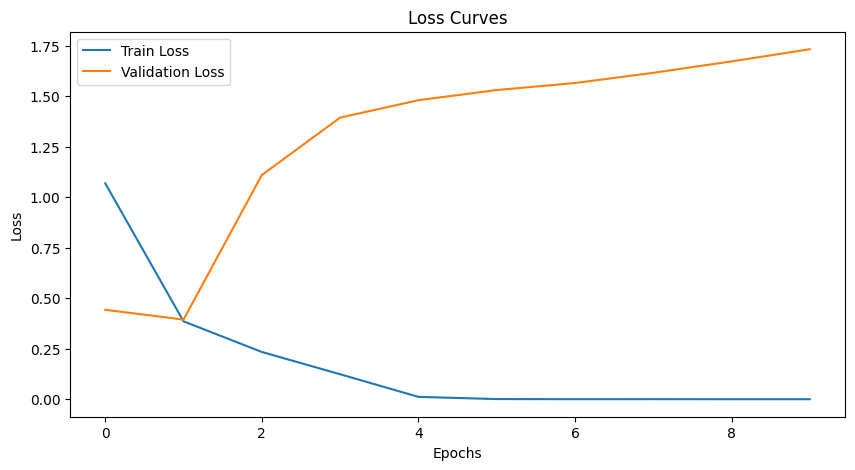

Test Loss: 1.733 | Test Accuracy: 75.00%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)  # input shape: [1, batch size]
        embedded = self.dropout(self.embedding(input))  # embedded shape: [1, batch size, emb dim]
        a = self.attention(hidden, encoder_outputs)  # attention shape: [batch size, src len]
        a = a.unsqueeze(1)  # attention shape: [batch size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # encoder_outputs shape: [batch size, src len, enc_hid_dim * 2]
        weighted = torch.bmm(a, encoder_outputs)  # weighted shape: [batch size, 1, enc_hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)  # weighted shape: [1, batch size, enc_hid_dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)  # rnn_input shape: [1, batch size, (enc_hid_dim * 2) + emb_dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        embedded = embedded.squeeze(0)  # embedded shape: [batch size, emb dim]
        output = output.squeeze(0)  # output shape: [batch size, dec_hid_dim]
        weighted = weighted.squeeze(0)  # weighted shape: [batch size, enc_hid_dim * 2]
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))  # prediction shape: [batch size, output_dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            top1 = output.argmax(1)
            input = trg[t] if random.random() < teacher_forcing_ratio else top1
        return outputs

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(model.device), trg.to(model.device)
        optimizer.zero_grad()

        # Ensure all indices are within the valid range
        src = torch.clamp(src, 0, INPUT_DIM - 1)
        trg = torch.clamp(trg, 0, OUTPUT_DIM - 1)

        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def accuracy(output, target):
    _, predicted = torch.max(output, dim=1)
    correct = (predicted == target).float()
    acc = correct.sum() / len(correct)
    return acc
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_acc = 0
    total_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src = src.permute(1, 0).to(device)
            trg = trg.permute(1, 0).to(device)

            # Ensure all indices are within the valid range
            src = torch.clamp(src, 0, INPUT_DIM - 1)
            trg = torch.clamp(trg, 0, OUTPUT_DIM - 1)

            output = model(src, trg, 0)  # no teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)

            # Use .reshape() instead of .view() to handle non-contiguous tensors
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)
            acc = accuracy(output, trg)
            total_loss += loss.item()
            total_acc += acc.item()
    return total_loss / len(dataloader), total_acc / len(dataloader)


# Example batch size
BATCH_SIZE = 32

# Custom collate function for DataLoader
def collate_fn(batch):
    srcs = [torch.tensor(item[0].copy()) for item in batch]
    trgs = [torch.tensor(item[1].copy()) for item in batch]
    srcs = pad_sequence(srcs, batch_first=True, padding_value=0)
    trgs = pad_sequence(trgs, batch_first=True, padding_value=0)
    return srcs, trgs

# Example dataset
# Replace with your actual dataset
class ExampleDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = [
            (np.array([1, 2, 3]), np.array([1, 2, 3])),
            (np.array([4, 5]), np.array([4, 5]))
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_data = ExampleDataset()

# DataLoader instantiation
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Define your vocabulary here
vocab = {'<PAD>': 0, '<SOS>': 1, '}': 2}

INPUT_DIM = len(vocab)
OUTPUT_DIM = len(vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Training loop
N_EPOCHS = 10
CLIP = 1

train_losses = []
val_losses = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    val_loss, _ = evaluate_model(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')

# Plotting loss curves
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()

plot_loss_curve(train_losses, val_losses)

# Evaluate the model
test_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc*100:.2f}%')
